In [1]:
# use observed streamflow data to evaluate model outputs
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, sys

sys.path.append('/glade/u/home/guoqiang/Statistical_repos/pyviscous')
import pyviscous

sys.path.append('../MOASMO_support/')
from mo_evaluation import main_read_CTSM_streamflow, read_CAMELS_Q_and_to_xarray, get_modified_KGE, get_RMSE, get_max_abs_error

# Load observed streamflow

In [2]:
infile_info = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/CAMELS_level1_basin_info.csv'
df_info = pd.read_csv(infile_info)

outpath = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs_evaluation'
os.makedirs(outpath, exist_ok=True)
outfile = f'{outpath}/obs_streamflow.nc'

In [3]:
ref_q_name = 'Runoff_cms'
ref_q_date = 'Date'
if os.path.isfile(outfile):
    ds_q_obs = xr.load_dataset(outfile)
else:
    ds_q_obs = [read_CAMELS_Q_and_to_xarray(file, ref_q_date, ref_q_name) for file in df_info['file_obsQ']]
    ds_q_obs = xr.concat(ds_q_obs, dim='lndgrid')
    ds_q_obs.to_netcdf(outfile)
    
ds_q_obs

<xarray.Dataset>
Dimensions:     (time: 12784, lndgrid: 627)
Coordinates:
  * time        (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2014-12-31
Dimensions without coordinates: lndgrid
Data variables:
    Runoff_cms  (lndgrid, time) float64 18.55 18.12 17.7 ... 79.57 69.66 61.16

# For each simulation, perform the evaluation and save the outputs

In [4]:
inpath0 = '/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/ctsm_outputs'
fsurdat = '/glade/work/guoqiang/CTSM_CAMELS/data_mesh_surf/HillslopeHydrology/sfcdata/surfdata_CAMELSandTDX_areabias_fix.simp0.001.level1_hist_78pfts_CMIP6_simyr2000_HAND_4_col_hillslope_geo_params_nlcd_bedrock.nc'

clm_q_name = 'QRUNOFF'
date_start = '2004-10-01'
date_end = '2009-09-30'
minfilenum = 7

ngrid = len(ds_q_obs.lndgrid)
niter = 40

for t in range(0, niter):
    # outfile metric
    outfile_metric = f'{outpath}/metric_iter0_trial{t}.csv'
    if os.path.isfile(outfile_metric):
        continue

    kge = np.nan * np.zeros(ngrid)
    maxabserror = np.nan * np.zeros(ngrid)
    rmse = np.nan * np.zeros(ngrid)
    # infiles
    CTSMfilelist = glob.glob(f'{inpath0}/iter0_trial{t}/lnd/hist/*h1*.nc')
    CTSMfilelist.sort()

    if len(CTSMfilelist)<minfilenum:
        print('Too few files for trial', t)
    else:
        # load variable
        ds_simu = main_read_CTSM_streamflow(fsurdat, CTSMfilelist, date_start, date_end, clm_q_name)
    
        # evaluation
        ds_q_obs = ds_q_obs.sel(time=ds_q_obs.time.isin(ds_simu.time))
        ds_simu = ds_simu.sel(time=ds_simu.time.isin(ds_q_obs.time))
    
        ds_q_obs[ref_q_name] = ds_q_obs[ref_q_name].where(ds_q_obs[ref_q_name] >= 0, np.nan)
        ds_simu[clm_q_name] = ds_simu[clm_q_name].where(ds_simu[clm_q_name] >= 0, np.nan)
            
        for l in range(ngrid):
            d1 = ds_q_obs[ref_q_name].sel(lndgrid=l).values
            d2 = ds_simu[clm_q_name].sel(lndgrid=l).values
            kge_q = get_modified_KGE(obs=d1, sim=d2)
            kge[l] = kge_q
    
            rmse_q = get_RMSE(obs=d1, sim=d2)
            rmse[l] = rmse_q
    
            d1 = ds_q_obs[ref_q_name].sel(lndgrid=l).groupby('time.month').mean().values
            d2 = ds_simu[clm_q_name].sel(lndgrid=l).groupby('time.month').mean().values
            maxabserror_q = get_max_abs_error(d1, d2)
            maxabserror[l] = maxabserror_q

    df_metric = pd.DataFrame({'KGEmod': kge, 'rmse':rmse, 'maxabserror':maxabserror})
    df_metric.to_csv(outfile_metric, index=False)

# Load all parameter values and all metrics to perform sensitivity analysis

## Load parameters

In [5]:
nparam = 27
params = np.nan * np.zeros([niter, nparam])

for i in range(niter):
    file = f'/glade/campaign/cgd/tss/people/guoqiang/CTSM_CAMELS_proj/SA_HH_allbasins/level1/param_sets/paramset_iter0_trial{i}.pkl'
    df_param = pd.read_pickle(file)
    va = df_param['Value'].values
    for j in range(nparam):
        params[i, j]=np.mean(va[j])

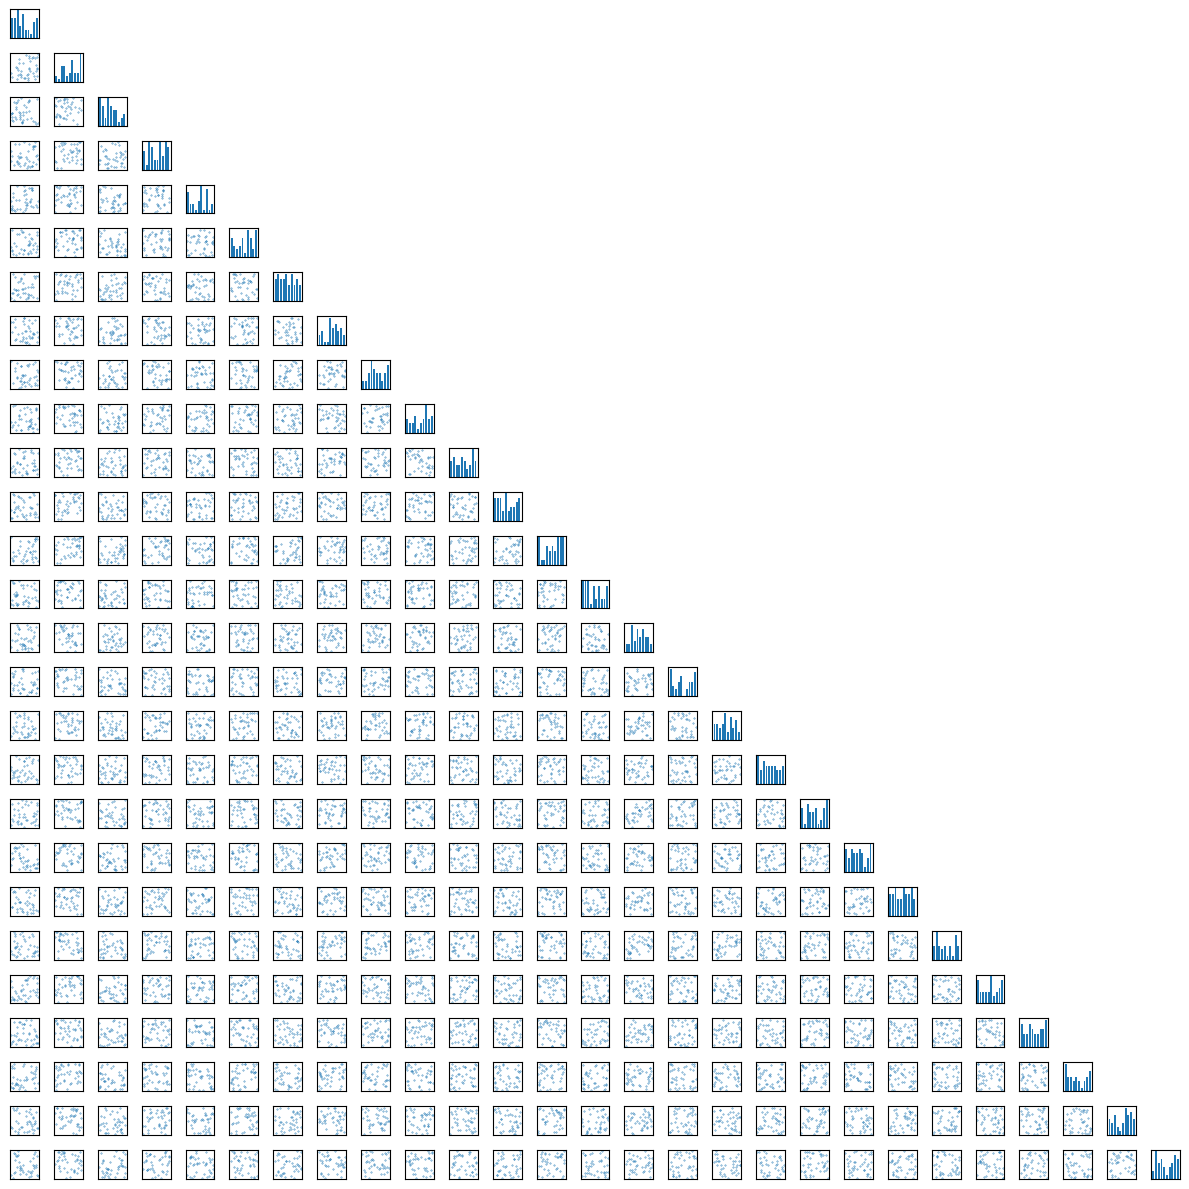

In [25]:
# # Scatter plots and histograms between all parameter pairs

# fig, axs = plt.subplots(nparam, nparam, figsize=[12, 12])

# for i in range(nparam):
#     for j in range(nparam):
#         ax = axs[i, j]
        
#         if j>i:
#             ax.axis('off')
            
#         elif j==i:
#             ax.hist(params[:,i], rwidth=0.7)
            
#             # Hide X and Y axes label marks
#             ax.xaxis.set_tick_params(labelbottom=False)
#             ax.yaxis.set_tick_params(labelleft=False)

#             # Hide X and Y axes tick marks
#             ax.set_xticks([])
#             ax.set_yticks([])
            
#         else:
        
#             ax.scatter(params[:,i], params[:,j], 0.1)

#             # Hide X and Y axes label marks
#             ax.xaxis.set_tick_params(labelbottom=False)
#             ax.yaxis.set_tick_params(labelleft=False)

#             # Hide X and Y axes tick marks
#             ax.set_xticks([])
#             ax.set_yticks([])
        
# plt.tight_layout()
# plt.show()

## Load evaluation metrics

In [6]:
kge = np.nan * np.zeros([niter, ngrid])
for t in range(0, niter):
    # outfile metric
    outfile_metric = f'{outpath}/metric_iter0_trial{t}.csv'
    df_metric = pd.read_csv(outfile_metric)
    kge[t, :] = df_metric['KGEmod'].values

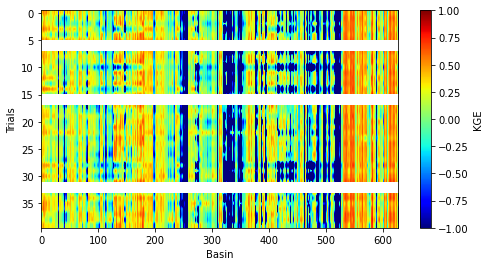

In [7]:
fig = plt.figure(figsize=[8, 4])            
plt.imshow(kge, aspect='auto', cmap='jet', vmin=-1, vmax=1)
plt.xlabel('Basin')
plt.ylabel('Trials')
plt.colorbar(label='KGE')
plt.show()

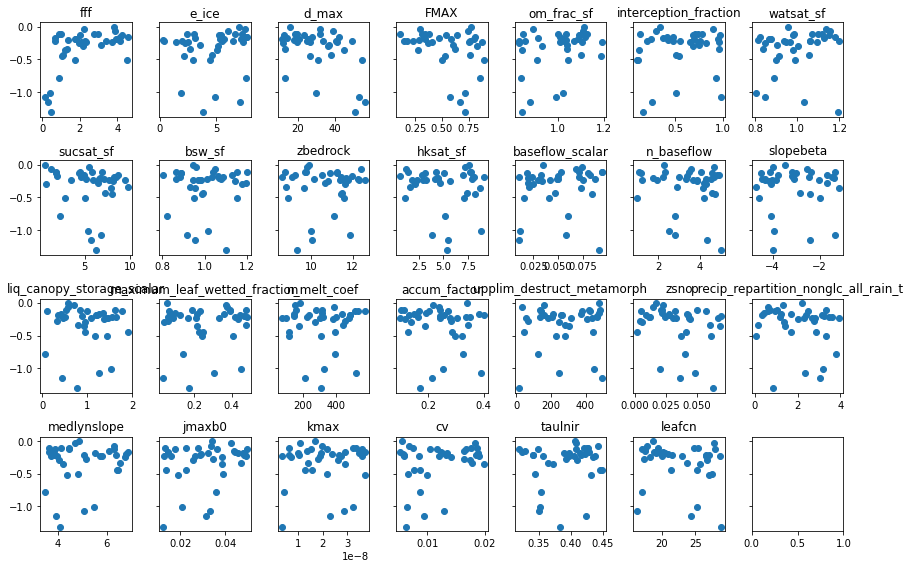

In [15]:
# plot inputs-output
fig, axs = plt.subplots(4, 7, figsize=(12, 8), sharey=True)
axs = axs.flatten()

kge_mean = np.nanmean(kge, axis=1)
paramanmes = df_param['Parameter'].values

for i in range(nparam):
    axs[i].scatter(params[:,i], kge_mean)
    axs[i].set_title(paramanmes[i])

plt.tight_layout()
plt.show()

## conduct sensivitiy analysis

### Calculate the first-order sensitivity index

In [ ]:
%%capture 
# avoid the too many printouts from pyviscous

for i in range(ngrid):
    x = params
    y = kge[:,i]
    ind = ~np.isnan(y)
    x, y = x[ind], y[ind]
    
    sens_indx_first = np.nan * np.zeros([nparam, ngrid])
    sens_indx_total = np.nan * np.zeros([nparam, ngrid])
    
    for xIndex in range(nparam): 
        sens_indx_first, gmcm_first = pyviscous.viscous(x, y, xIndex, 'first', MSC='AIC',verbose=False) 
        sens_indx_total, gmcm_total = pyviscous.viscous(x, y, xIndex, 'total', MSC='AIC')     

In [32]:
kge.shape

(40, 627)

In [33]:
params.shape

(40, 27)